In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import math

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, num_features))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, num_features))

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError()
        return x

    def _get_statistics(self, x):
        self.mean = torch.mean(x, dim=1, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x)
        return self.dropout(x)

class DACStructure(nn.Module):
    def __init__(self, win_size, patch_size, channel, scale=None, attention_dropout=0.1):
        super(DACStructure, self).__init__()
        self.scale = scale
        self.dropout = nn.Dropout(attention_dropout)
        self.window_size = win_size
        self.patch_size = patch_size
        self.channel = channel

    def forward(self, queries_patch_size, keys_patch_size, queries_patch_num, keys_patch_num, patch_index):
        B, L_ps, H, E_ps = queries_patch_size.shape
        _, L_pn, _, E_pn = queries_patch_num.shape

        scale_patch_size = self.scale or 1. / math.sqrt(E_ps)
        scores_patch_size = torch.einsum("blhe,bshe->bhls", queries_patch_size, keys_patch_size)
        attn_patch_size = scale_patch_size * scores_patch_size
        series_patch_size = self.dropout(torch.softmax(attn_patch_size, dim=-1))
        
        current_patch_size = self.patch_size[patch_index]
        series_patch_size = repeat(series_patch_size, 'b h m n -> b h (m p1) (n p2)', p1=current_patch_size, p2=current_patch_size)
        
        scale_patch_num = self.scale or 1. / math.sqrt(E_pn)
        scores_patch_num = torch.einsum("blhe,bshe->bhls", queries_patch_num, keys_patch_num)
        attn_patch_num = scale_patch_num * scores_patch_num
        series_patch_num = self.dropout(torch.softmax(attn_patch_num, dim=-1))
        
        num_patches = self.window_size // current_patch_size
        series_patch_num = repeat(series_patch_num, 'b h m n -> b h (m p1) (n p2)', p1=num_patches, p2=num_patches)

        return series_patch_size, series_patch_num

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads):
        super(AttentionLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.query_projection_patch_size = nn.Linear(d_model, d_model)
        self.key_projection_patch_size = nn.Linear(d_model, d_model)
        self.query_projection_patch_num = nn.Linear(d_model, d_model)
        self.key_projection_patch_num = nn.Linear(d_model, d_model)
        
        self.attention = attention
        
        self.out_projection = nn.Linear(d_model, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model*2), nn.GELU(), nn.Linear(d_model*2, d_model))

    def forward(self, x_patch_size, x_patch_num, patch_index):
        B_ps, N_ps, D_ps = x_patch_size.shape
        B_pn, N_pn, D_pn = x_patch_num.shape

        queries_patch_size = self.query_projection_patch_size(x_patch_size).view(B_ps, N_ps, self.n_heads, -1)
        keys_patch_size = self.key_projection_patch_size(x_patch_size).view(B_ps, N_ps, self.n_heads, -1)
        
        queries_patch_num = self.query_projection_patch_num(x_patch_num).view(B_pn, N_pn, self.n_heads, -1)
        keys_patch_num = self.key_projection_patch_num(x_patch_num).view(B_pn, N_pn, self.n_heads, -1)

        patch_wise, in_patch = self.attention(
            queries_patch_size, keys_patch_size,
            queries_patch_num, keys_patch_num,
            patch_index
        )
        
        return patch_wise, in_patch

class Encoder(nn.Module):
    def __init__(self, attn_layers):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)

    def forward(self, x_patch_size, x_patch_num, patch_index):
        for attn_layer in self.attn_layers:
            patch_wise, in_patch = attn_layer(x_patch_size, x_patch_num, patch_index)
        return patch_wise, in_patch

class DCdetector(nn.Module):
    def __init__(self, win_size, enc_in, n_heads, d_model, e_layers, patch_size, d_ff=None, dropout=0.1, channel=1): # channel 參數現在代表 enc_in
        super(DCdetector, self).__init__()
        self.win_size = win_size
        self.patch_size = patch_size
        self.revin_layer = RevIN(num_features=enc_in)
        self.channel = channel # 保存通道數

        self.embedding_patch_size = nn.ModuleList()
        self.embedding_patch_num = nn.ModuleList()
        for i, p_size in enumerate(self.patch_size):
            # 讓嵌入層能處理多通道。每個 patch 的輸入維度是 p_size * channel
            self.embedding_patch_size.append(DataEmbedding(p_size * self.channel, d_model, dropout)) 
            
            num_patches = self.win_size // p_size
            # 數字嵌入層也需要考慮多通道
            self.embedding_patch_num.append(DataEmbedding(num_patches * self.channel, d_model, dropout))

        self.encoder = Encoder(
            [
                AttentionLayer(
                    DACStructure(win_size, patch_size, channel, attention_dropout=dropout),
                    d_model, n_heads
                ) for l in range(e_layers)
            ]
        )

    def forward(self, x):
        B, L, M = x.shape # M 就是通道數
        x = self.revin_layer(x, 'norm')
        # x = x.permute(0, 2, 1) # 不再需要，或根據後續維度調整
        # x = x.reshape(B * M, L, 1) # 【關鍵】移除這行！

        patch_wise_final = []
        in_patch_final = []

        for i, p_size in enumerate(self.patch_size):
            num_patches = self.win_size // p_size
            
            # 將 patch 和 channel 維度合併，送入 embedding 層
            x_patch_size = rearrange(x, 'b (n p) m -> b n (p m)', p=p_size)
            x_patch_size_emb = self.embedding_patch_size[i](x_patch_size)

            x_patch_num = rearrange(x, 'b (n p) m -> b p (n m)', p=p_size)
            x_patch_num_emb = self.embedding_patch_num[i](x_patch_num)

            # Encoder 的輸入維度是正確的 (B, N, D_model)，不需更改
            patch_wise, in_patch = self.encoder(x_patch_size_emb, x_patch_num_emb, i)
            patch_wise_final.append(patch_wise)
            in_patch_final.append(in_patch)

        patch_wise_out = torch.stack(patch_wise_final, dim=0).mean(dim=0)
        in_patch_out = torch.stack(in_patch_final, dim=0).mean(dim=0)
        
        # 【注意】這裡的 reshape 可能需要調整或移除，因為 M 維度已經被編碼到模型中了
        # Anomaly Score 的計算可能也需要適應新的輸出形狀
        # 最終的 anomaly score 應該是針對整個多通道樣本，而不是每個通道
        # patch_wise_out = patch_wise_out.view(B, M, ... ) # <<<< 這行可能需要修改
        # in_patch_out = in_patch_out.view(B, M, ... )   # <<<< 這行可能需要修改
        
        return patch_wise_out, in_patch_out

class DCAgent:
    def __init__(self, model, optimizer, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.history = list()
    
    def _calculate_loss(self, patch_wise_out, in_patch_out):
        # ==================== MODIFICATION START ====================
        # This section is modified based on a re-analysis of the paper's intent.
        # The paper's Eq. (10) `L = (L_N - L_P)` is considered a typo, as it results in zero loss.
        # The corrected, functional loss should be a sum, consistent with the paper's goal of
        # measuring "similarity"  and the existence of experimental results.
        # N: patch_wise_out (patch-wise representation)
        # P: in_patch_out (in-patch representation)

        # Pre-calculate distributions
        N_dist = F.softmax(patch_wise_out, dim=-1)
        log_N_dist = F.log_softmax(patch_wise_out, dim=-1)
        N_dist_detached = N_dist.detach()
        log_N_dist_detached = log_N_dist.detach()

        P_dist = F.softmax(in_patch_out, dim=-1)
        log_P_dist = F.log_softmax(in_patch_out, dim=-1)
        P_dist_detached = P_dist.detach()
        log_P_dist_detached = log_P_dist.detach()
        
        # Eq (8): L_P = sum(KL(P || Stopgrad(N)) + KL(Stopgrad(N) || P))
        # This loss term only computes gradients for P (in_patch_out)
        kl_P_Nsg = F.kl_div(log_N_dist_detached, P_dist, reduction='none').sum(dim=(-1, -2))
        kl_Nsg_P = F.kl_div(log_P_dist, N_dist_detached, reduction='none').sum(dim=(-1, -2))
        loss_p = kl_P_Nsg + kl_Nsg_P

        # Eq (9): L_N = sum(KL(N || Stopgrad(P)) + KL(Stopgrad(P) || N))
        # This loss term only computes gradients for N (patch_wise_out)
        kl_N_Psg = F.kl_div(log_P_dist_detached, N_dist, reduction='none').sum(dim=(-1, -2))
        kl_Psg_N = F.kl_div(log_N_dist, P_dist_detached, reduction='none').sum(dim=(-1, -2))
        loss_n = kl_N_Psg + kl_Psg_N
        
        # Corrected Eq (10): L = (L_N + L_P) / len(N)
        # Using addition (+) instead of subtraction (-) to create a meaningful, non-zero loss.
        total_loss = (loss_n + loss_p).mean()

        return total_loss
        # ===================== MODIFICATION END =====================

    def train(self, dataloader, epochs):
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for x_batch, in dataloader:
                x_batch = x_batch.to(self.device)
                self.optimizer.zero_grad()
                
                patch_wise_out, in_patch_out = self.model(x_batch)
                loss = self._calculate_loss(patch_wise_out, in_patch_out)
                
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            self.history += [total_loss / len(dataloader)]
            print("[Epoch {}] Loss = {}".format(epoch+1, total_loss/len(dataloader)))
        
        return self.history

    def _calculate_anomaly_score(self, patch_wise_out, in_patch_out):
        # This section literally implements Equation (11) from the paper.
        # AnomalyScore(X) = sum(KL(P, Stopgrad(N)) + KL(N, Stopgrad(P)))
        # During inference, Stopgrad (detach) has no effect on the value but makes the code match the paper.
        B, M, L, _ = patch_wise_out.shape
        scores = torch.zeros(B, M, L, device=self.device)

        with torch.no_grad(): # Ensure no gradients are computed during scoring
            for i in range(L):
                # N is patch_wise_out, P is in_patch_out
                p_i = F.softmax(patch_wise_out[:, :, i, :], dim=-1)
                n_i = F.softmax(in_patch_out[:, :, i, :], dim=-1)
                
                # According to the paper's formula, which includes Stopgrad
                p_i_detached = p_i.detach()
                n_i_detached = n_i.detach()

                # Term 1: KL(P, Stopgrad(N)) is implemented as KL(n_i || p_i_detached)
                kl_n_p_sg = F.kl_div(p_i_detached.log(), n_i, reduction='none').sum(dim=-1)
                
                # Term 2: KL(N, Stopgrad(P)) is implemented as KL(p_i || n_i_detached)
                kl_p_n_sg = F.kl_div(n_i_detached.log(), p_i, reduction='none').sum(dim=-1)
                
                # The total score is the sum
                scores[:, :, i] = kl_n_p_sg + kl_p_n_sg
        
        return scores.permute(0,2,1)

    def predict(self, dataloader):
        self.model.eval()
        all_scores = []
        # No need for torch.no_grad() here as it's handled inside _calculate_anomaly_score
        for x_batch, in dataloader:
            x_batch = x_batch.to(self.device)
            patch_wise_out, in_patch_out = self.model(x_batch)
            scores = self._calculate_anomaly_score(patch_wise_out, in_patch_out)
            all_scores.append(scores.cpu())
        
        return torch.cat(all_scores, dim=0)

In [2]:
def mock_data(n_batch):
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore")
    data = list()
    for _ in range(n_batch):
        arr = list()
        scale = float(np.random.normal(60, 1, size = (1, )))
        first_seg = (scale*np.random.normal(1, 0.02, size = (42, ))).tolist() 

        scale = float(np.random.normal(-10, 2, size = (1, )))
        second_seg = (scale*(np.ones(shape = (50, )))).tolist()

        scale = float(np.random.normal(70, 1, size = (1, )))
        third_seg = (scale*(np.ones(shape = (13, )))).tolist()

        arr += [first_seg + second_seg + third_seg]

        scale = float(np.random.normal(70, 1, size = (1, )))
        first_seg = (scale*(np.ones(shape = (42, )))).tolist()

        scale = float(np.random.normal(60, 1, size = (1, )))
        third_seg = (scale*np.random.normal(1, 0.02, size = (63, ))).tolist() 
        arr += [first_seg +  third_seg]

        arr = np.concatenate([np.array(arr[0]).reshape(-1, 1), np.array(arr[1]).reshape(-1, 1)], axis = 1)
        data += [arr.copy()]
    return np.stack(data)

In [3]:
if __name__ == '__main__':
    win_size = 105
    patch_size = [5, 7]
    enc_in = 2
    d_model = 256
    n_heads = 1
    e_layers = 3
    batch_size = 128
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = DCdetector(
        win_size=win_size,
        enc_in=enc_in,
        n_heads=n_heads,
        d_model=d_model,
        e_layers=e_layers,
        patch_size=patch_size,
        channel=enc_in
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    agent = DCAgent(model, optimizer, device)
    
    # dummy_data = torch.randn(batch_size * 5, win_size, enc_in)
    dummy_data = torch.tensor(mock_data(512), dtype = torch.float32)
    dummy_dataset = torch.utils.data.TensorDataset(dummy_data)
    dummy_dataloader = torch.utils.data.DataLoader(dummy_dataset, batch_size=batch_size)
    
    print("Starting training with paper-consistent (and corrected) loss function...")
    avg_loss = agent.train(dummy_dataloader, epochs = 150)
    print(f"Training finished. Average loss: {avg_loss[-1]:.4f}")
    
    print("\nStarting prediction with paper-consistent anomaly score...")
    anomaly_scores = agent.predict(dummy_dataloader)
    print("Prediction finished.")
    print(f"Output anomaly scores shape: {anomaly_scores.shape}")
    print(f"Expected shape: {(dummy_data.shape[0], win_size, enc_in)}")
    
    single_score_example = anomaly_scores[0, :, 0]
    print(f"\nExample anomaly score for first sample, first channel (first 10 points): \n{single_score_example[:10]}")

Starting training with paper-consistent (and corrected) loss function...
[Epoch 1] Loss = 0.33005403727293015
[Epoch 2] Loss = 0.3179282695055008
[Epoch 3] Loss = 0.321370966732502
[Epoch 4] Loss = 0.32408639788627625
[Epoch 5] Loss = 0.3305903449654579
[Epoch 6] Loss = 0.31553806364536285
[Epoch 7] Loss = 0.3195965066552162
[Epoch 8] Loss = 0.3176059424877167
[Epoch 9] Loss = 0.315379336476326
[Epoch 10] Loss = 0.32081206142902374
[Epoch 11] Loss = 0.3221360370516777
[Epoch 12] Loss = 0.3197200298309326
[Epoch 13] Loss = 0.3240762874484062
[Epoch 14] Loss = 0.3258325308561325
[Epoch 15] Loss = 0.32299885898828506
[Epoch 16] Loss = 0.31254640966653824
[Epoch 17] Loss = 0.33241718262434006
[Epoch 18] Loss = 0.31915922462940216
[Epoch 19] Loss = 0.3169105499982834
[Epoch 20] Loss = 0.31901200115680695
[Epoch 21] Loss = 0.3134781941771507
[Epoch 22] Loss = 0.3210374265909195
[Epoch 23] Loss = 0.3176366686820984
[Epoch 24] Loss = 0.31965383142232895
[Epoch 25] Loss = 0.32019226998090744
[E

In [16]:
def mock_data_ts(n_batch):
    import numpy as np
    data = list()
    for _ in range(n_batch):
        arr = list()
        scale = float(np.random.normal(60, 1, size = (1, )))
        first_seg = (scale*np.random.normal(1, 0.02, size = (42, ))).tolist() 

        scale = float(np.random.normal(-10, 2, size = (1, )))
        second_seg = (scale*(np.ones(shape = (50, )))).tolist()

        scale = float(np.random.normal(70, 1, size = (1, )))
        third_seg = (scale*(np.ones(shape = (13, )))).tolist()

        arr += [first_seg + second_seg + third_seg]

        scale = float(np.random.normal(60, 1, size = (1, )))
        first_seg = (scale*np.random.normal(1, 0.02, size = (42, ))).tolist() 

        scale = float(np.random.normal(-10, 2, size = (1, )))
        second_seg = (scale*(np.ones(shape = (50, )))).tolist()

        scale = float(np.random.normal(70, 1, size = (1, )))
        third_seg = (scale*(np.ones(shape = (13, )))).tolist()

        arr += [first_seg + second_seg + third_seg]

        arr = np.concatenate([np.array(arr[0]).reshape(-1, 1), np.array(arr[1]).reshape(-1, 1)], axis = 1)
        data += [arr.copy()]
    return np.stack(data)


Example anomaly score for first sample, first channel (first 10 points): 
tensor([1.2666e-07, 1.2666e-07, 1.2666e-07, 1.2666e-07, 1.2666e-07, 2.4587e-07,
        2.4587e-07, 1.2666e-07, 1.2666e-07, 1.2666e-07])

Example anomaly score for first sample, first channel (first 10 points): 
tensor([8.7917e-07, 8.7917e-07, 8.7917e-07, 8.7917e-07, 8.7917e-07, 9.7230e-07,
        9.7230e-07, 9.3505e-07, 9.3505e-07, 9.3505e-07])


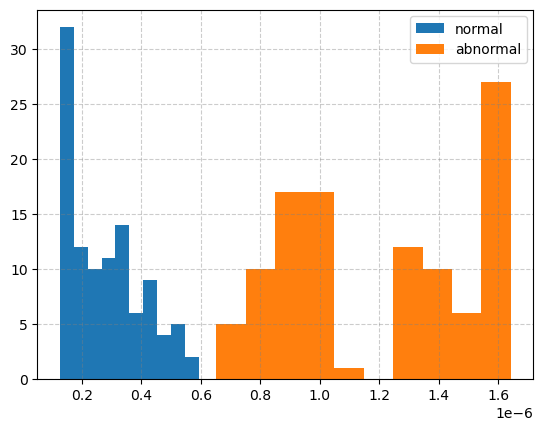

In [32]:
import matplotlib.pyplot as plt
dummy_data = torch.tensor(mock_data(1), dtype = torch.float32)
dummy_dataset = torch.utils.data.TensorDataset(dummy_data)
dummy_dataloader = torch.utils.data.DataLoader(dummy_dataset, batch_size=batch_size)
anomaly_scores = agent.predict(dummy_dataloader)
single_score_example = anomaly_scores[0, :, 0]
plt.hist(anomaly_scores.reshape(-1, ).tolist(), label = "normal")
print(f"\nExample anomaly score for first sample, first channel (first 10 points): \n{single_score_example[:10]}")

dummy_data = torch.tensor(mock_data_ts(1), dtype = torch.float32)
dummy_dataset = torch.utils.data.TensorDataset(dummy_data)
dummy_dataloader = torch.utils.data.DataLoader(dummy_dataset, batch_size=batch_size)
anomaly_scores = agent.predict(dummy_dataloader)
single_score_example = anomaly_scores[0, :, 0]
plt.hist(anomaly_scores.reshape(-1, ).tolist(), label = "abnormal")
print(f"\nExample anomaly score for first sample, first channel (first 10 points): \n{single_score_example[:10]}")
plt.grid(color = "gray", linestyle = "--", alpha = .4)
plt.legend()
plt.show()

In [ ]:
torch.anomaly_scores.shape

torch.Size([2, 105, 1])